### Notebook to calculate the area-weighted annual SST within Aotearoa's Exclusive Economic Zone

data sources: 

- ERSST: [http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc](http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc)
- shapefile with the World's EEZ: [https://www.marineregions.org/downloads.php](https://www.marineregions.org/downloads.php ) 

### imports 

In [1]:
%matplotlib inline

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
import regionmask

In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

In [4]:
import sys

In [5]:
sys.path.append('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/')

In [6]:
from ICU_Water_Watch import utils, geo

### reads the shapefile containing the world's EEZ as polygons

In [7]:
shp = gpd.read_file('../data/World_EEZ_v11_20191118_HR_0_360/eez_v11_0_360.shp') 

In [8]:
shp.head()

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
0,8357.0,Kuwaiti Exclusive Economic Zone,2115.0,200NM,2115.0,Kuwait,KWT,Kuwait,0.0,0.0,...,KWT,None,None,414.0,NaN,NaN,414.0,NaN,NaN,"MULTIPOLYGON (((47.97083 29.99681, 47.97161 29..."
1,8310.0,Norfolk Island Exclusive Economic Zone,8591.0,200NM,2147.0,Norfolk Island,NFK,Australia,0.0,0.0,...,AUS,None,None,36.0,NaN,NaN,574.0,NaN,NaN,"POLYGON ((169.42984 -25.93061, 169.43003 -25.9..."
2,8373.0,Syrian Exclusive Economic Zone,3384.0,200NM,3384.0,Syria,SYR,Syria,0.0,0.0,...,SYR,None,None,760.0,NaN,NaN,760.0,NaN,NaN,"POLYGON ((35.91810 35.92989, 35.91752 35.92882..."
3,62596.0,Colombian Exclusive Economic Zone (Serrana),5770.0,200NM,2175.0,Serrana Bank,None,Colombia,0.0,0.0,...,COL,None,None,170.0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((279.76139 14.67328, 279.76346 14.673..."
4,8343.0,Mauritian Exclusive Economic Zone,8614.0,200NM,8614.0,Republic of Mauritius,MUS,Republic of Mauritius,0.0,0.0,...,MUS,None,None,480.0,NaN,NaN,480.0,NaN,NaN,"POLYGON ((58.24359 -23.80956, 58.23972 -23.801..."


### select only NZ's economic zone

In [9]:
shp = shp.query("GEONAME == 'New Zealand Exclusive Economic Zone'")

In [10]:
shp

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
205,8455.0,New Zealand Exclusive Economic Zone,2227.0,200NM,2227.0,New Zealand,NZL,New Zealand,0.0,0.0,...,NZL,None,None,554.0,NaN,NaN,554.0,NaN,NaN,"POLYGON ((180.00000 -52.95699, 180.00000 -52.9..."


<AxesSubplot:>

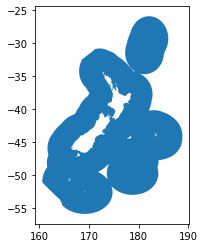

In [11]:
shp.plot()

### save to file for later use

In [12]:
shp.to_file('../data/NZ_EEZ.GeoJSON', driver='GeoJSON')

### Now reads in the ERSST dataset (from the NOAA's openDAP server)

In [13]:
url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"	

In [14]:
ds = xr.open_dataset(url, drop_variables=["time_bnds"])

### select period here 

In [15]:
ds = ds.sel(time=slice('1909','2021'))

In [16]:
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1356)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1909-01-01 1909-02-01 ... 2021-12-01
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-02-07
    DODS_EXTRA.Unlimited_Dimension:  time

### flip the latitudes 

In [17]:
ds = ds.sortby('lat')

### quick plots to check values 

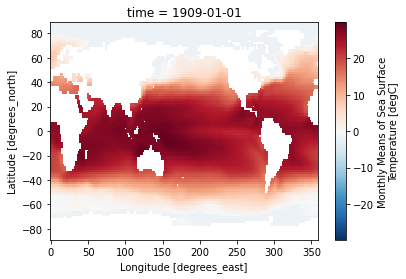

In [18]:
ds['sst'][0,:,:].plot()

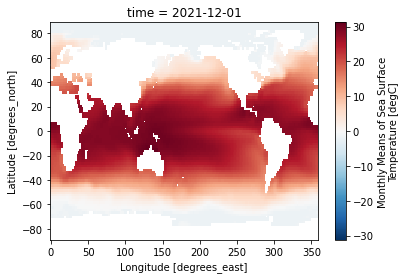

In [19]:
ds['sst'][-1,:,:].plot()

### interpolate to higher resolution 

In [20]:
ds = utils.interp(ds, interp_factor=5)

In [21]:
clim = ds.sel(time=slice('1981','2010'))

In [22]:
clim = clim.groupby(clim.time.dt.month).mean('time')

In [23]:
anomalies = ds.groupby(ds.time.dt.month) - clim

### interpolates the NaNs

In [ ]:
sst_interp = utils.interpolate_NaN_da(anomalies['sst'])

### function to create a mask from a geopandas dataframe containing polygons

In [28]:
anomalies = geo.make_mask_from_gpd(anomalies, shp, insert=True)

### the dataset is now subsetted 

<GeoAxesSubplot:title={'center':'time = 2021-12-01, month = 12'}, xlabel='lon', ylabel='lat'>

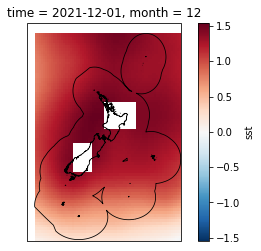

In [29]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
anomalies['sst'][-1,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)

### mask

<GeoAxesSubplot:xlabel='lon', ylabel='lat'>

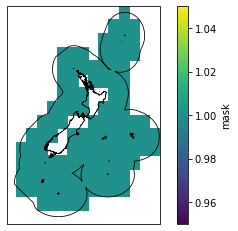

In [27]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
ds['mask'].plot(ax=ax, transform=ccrs.PlateCarree())
shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)

### multiply the SSTs by the mask 

In [20]:
ds['sst_masked'] = ds['sst'] * ds['mask']

<GeoAxesSubplot:title={'center':'time = 2021-12-01'}, xlabel='lon', ylabel='lat'>

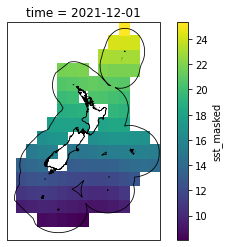

In [21]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
ds['sst_masked'][-1,:,:].plot(ax=ax, transform=ccrs.PlateCarree())
shp.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='k', linewidth=0.8)

### number of grid points inside the EEZ

In [22]:
len(ds['sst_masked'].stack(z=('lat','lon')).dropna('z')['z'])

112

### creates the weights (cosine of the latitude)

In [23]:
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 16)>
array([0.5591929 , 0.58778524, 0.6156615 , 0.6427876 , 0.66913056,
       0.6946584 , 0.7193398 , 0.7431448 , 0.76604444, 0.7880108 ,
       0.809017  , 0.8290376 , 0.8480481 , 0.8660254 , 0.88294756,
       0.89879405], dtype=float32)
Coordinates:
  * lat      (lat) float32 -56.0 -54.0 -52.0 -50.0 ... -32.0 -30.0 -28.0 -26.0

### weighted mean

In [24]:
sst_weighted = ds['sst_masked'].weighted(weights)

In [25]:
sst_weighted_mean = sst_weighted.mean(['lat','lon'])

### non weighted mean for comparison 

In [26]:
sst_mean = ds['sst_masked'].mean(['lat','lon'])

### difference between weighted and un-weighted mean 

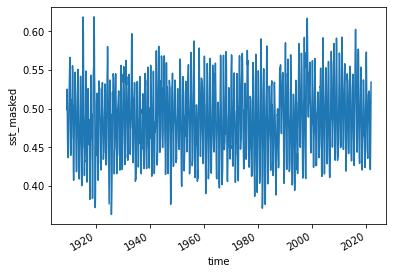

In [27]:
(sst_weighted_mean - sst_mean).plot()

### it's systematically warmer, which makes sense as the weights are larger as you go from S to N 

### plot of the area weigthed mean time-series for NZ's EEZ 

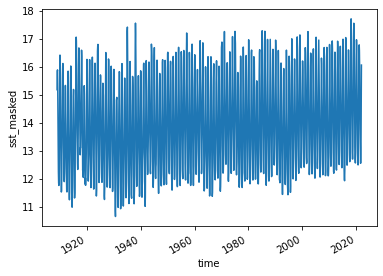

In [28]:
sst_weighted_mean.plot()

### check the seasonal cycles of both unweighted and weighted mean

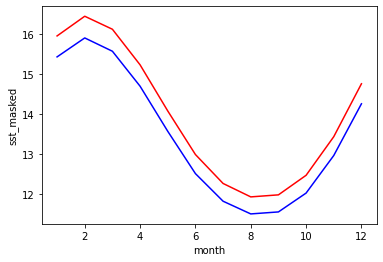

In [29]:
f, ax = plt.subplots()
sst_weighted_mean.groupby(sst_weighted_mean.time.dt.month).mean().plot(ax=ax, color='r')
sst_mean.groupby(sst_mean.time.dt.month).mean().plot(ax=ax, color='b')

### calculates the annual averages ('raw' data)

In [30]:
sst_weighted_mean_annual = sst_weighted_mean.resample({'time':'A'}).mean()

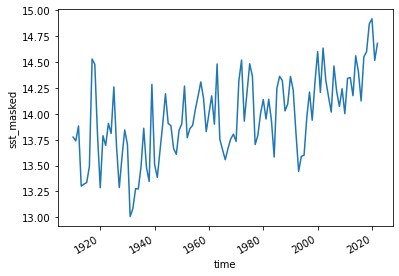

In [31]:
sst_weighted_mean_annual.plot()

In [32]:
sst_weighted_mean_annual = sst_weighted_mean_annual.to_pandas()

In [33]:
sst_weighted_mean_annual = sst_weighted_mean_annual.to_frame(name='NZ_SST')

### sort 

In [34]:
sorted_sst_weighted_mean_annual = sst_weighted_mean_annual.sort_values(ascending=False, by='NZ_SST')

In [35]:
sorted_sst_weighted_mean_annual.head()

,NZ_SST
time,
2019-12-31,14.919031
2018-12-31,14.870470
2021-12-31,14.681916
2001-12-31,14.636129
1999-12-31,14.602630


In [36]:
sorted_sst_weighted_mean_annual.loc[:,'rank'] = np.arange(len(sorted_sst_weighted_mean_annual)) + 1

In [37]:
sorted_sst_weighted_mean_annual.head()

,NZ_SST,rank
time,,
2019-12-31,14.919031,1
2018-12-31,14.870470,2
2021-12-31,14.681916,3
2001-12-31,14.636129,4
1999-12-31,14.602630,5


### calculates the climatology, to express values in terms of anomalies 

In [38]:
climo = sst_weighted_mean_annual.loc['1981':'2010',:].mean()

In [39]:
sst_weighted_mean_annual_anoms = sst_weighted_mean_annual - climo

<AxesSubplot:xlabel='time'>

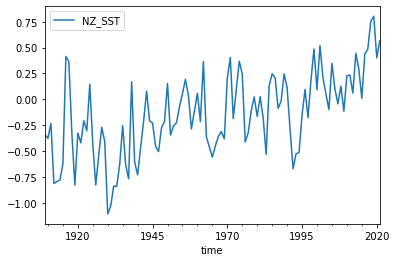

In [40]:
sst_weighted_mean_annual_anoms.plot()

In [41]:
sst_weighted_mean_annual_anoms.sort_values(ascending=False, by='NZ_SST').head()

,NZ_SST
time,
2019-12-31,0.802790
2018-12-31,0.754230
2021-12-31,0.565675
2001-12-31,0.519889
1999-12-31,0.486390


### rename, concatenate and save to disk 

In [43]:
sst_weighted_mean_annual_anoms.columns = ['NZ_EEZ_SST_anomalies']

In [45]:
sst_weighted_mean_annual.columns = ['NZ_EEZ_SST']

In [47]:
sst = pd.concat([sst_weighted_mean_annual, sst_weighted_mean_annual_anoms], axis=1)

In [48]:
sst.to_csv('/home/nicolasf/Desktop/NZ_EEZ_SST_annual.csv')